In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import evaluate
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
)


In [2]:
# Setup evaluation
metric = evaluate.load("accuracy")


# accuracy metric for classification
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [3]:
# create DictDataset from data from data_analysis.ipynb
dataset = (
    # load data
    Dataset.from_csv("news/data.csv")
    # remove index column
    .remove_columns("Unnamed: 0")
    # rename categories to labels as model demands
    .rename_column("news_category", "labels")
    # encode labels to be integers
    .class_encode_column("labels")
    # split dataset to train and test with respect to labels (proportionally)
    .train_test_split(test_size=0.1, stratify_by_column="labels", seed=42)
)

# extract classes in their specified order as .class_encode_column did
classes = dataset["test"].features["labels"].names

# define checkpoint and load tokenizer (and model later)
checkpoint = "distilbert/distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# during training batches need to be padded so their sizes match
data_collator = DataCollatorWithPadding(tokenizer)

# model will be trained on headlines and articles themselves
# if some sentence is too long, truncate it (model_max_length = 512)
def tokenize_headlines_and_articles(data):
    return tokenizer(data["news_headline"] + data["news_article"], truncation=True)


dataset = dataset.map(tokenize_headlines_and_articles)

c:\Users\user\Documents\distilbert-finetuning\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/1212 [00:00<?, ? examples/s]

# Training Classifier Only

In [4]:
# load the model from hugging face checkpoint
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=7, ignore_mismatched_sizes=True)

# freeze the whole model except for last layer
model.requires_grad_(False)
model.classifier.requires_grad_(True)

# set correct labels in config.json file
model.config.id2label = {idx: cls for idx, cls in enumerate(classes)}
model.config.label2id = {cls: idx for idx, cls in enumerate(classes)}

# setup training arguments
training_args = TrainingArguments(
    output_dir="checkpoints/classifier_only",
    num_train_epochs=5,
    evaluation_strategy="steps",
    save_strategy="steps",
    # these two params will save best and last models only
    save_total_limit=1,
    load_best_model_at_end=True,
    logging_dir="logs/classifier_only",
)

trainer = Trainer(
    model,
    training_args,
    data_collator,
    dataset["train"],
    dataset["test"],
    tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased-finetuned-sst-2-english and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/6820 [00:00<?, ?it/s]

{'loss': 1.8994, 'grad_norm': 4.608667373657227, 'learning_rate': 4.6334310850439885e-05, 'epoch': 0.37}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.8701764345169067, 'eval_accuracy': 0.24257425742574257, 'eval_runtime': 10.3148, 'eval_samples_per_second': 117.502, 'eval_steps_per_second': 14.736, 'epoch': 0.37}
{'loss': 1.8577, 'grad_norm': 4.975484848022461, 'learning_rate': 4.266862170087977e-05, 'epoch': 0.73}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.8432567119598389, 'eval_accuracy': 0.2524752475247525, 'eval_runtime': 10.3407, 'eval_samples_per_second': 117.207, 'eval_steps_per_second': 14.699, 'epoch': 0.73}
{'loss': 1.828, 'grad_norm': 3.1112263202667236, 'learning_rate': 3.900293255131965e-05, 'epoch': 1.1}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.8263930082321167, 'eval_accuracy': 0.283003300330033, 'eval_runtime': 10.3964, 'eval_samples_per_second': 116.579, 'eval_steps_per_second': 14.62, 'epoch': 1.1}
{'loss': 1.8112, 'grad_norm': 4.610632419586182, 'learning_rate': 3.533724340175953e-05, 'epoch': 1.47}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.8013731241226196, 'eval_accuracy': 0.2962046204620462, 'eval_runtime': 10.4142, 'eval_samples_per_second': 116.379, 'eval_steps_per_second': 14.595, 'epoch': 1.47}
{'loss': 1.797, 'grad_norm': 4.988510608673096, 'learning_rate': 3.1671554252199416e-05, 'epoch': 1.83}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.7829703092575073, 'eval_accuracy': 0.31600660066006603, 'eval_runtime': 10.3035, 'eval_samples_per_second': 117.63, 'eval_steps_per_second': 14.752, 'epoch': 1.83}
{'loss': 1.7753, 'grad_norm': 4.541322231292725, 'learning_rate': 2.8005865102639295e-05, 'epoch': 2.2}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.7686924934387207, 'eval_accuracy': 0.32425742574257427, 'eval_runtime': 10.2024, 'eval_samples_per_second': 118.796, 'eval_steps_per_second': 14.899, 'epoch': 2.2}
{'loss': 1.7498, 'grad_norm': 5.281487464904785, 'learning_rate': 2.434017595307918e-05, 'epoch': 2.57}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.7565982341766357, 'eval_accuracy': 0.3333333333333333, 'eval_runtime': 10.3446, 'eval_samples_per_second': 117.162, 'eval_steps_per_second': 14.694, 'epoch': 2.57}
{'loss': 1.7577, 'grad_norm': 3.8044631481170654, 'learning_rate': 2.0674486803519064e-05, 'epoch': 2.93}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.7430026531219482, 'eval_accuracy': 0.3589108910891089, 'eval_runtime': 10.2987, 'eval_samples_per_second': 117.685, 'eval_steps_per_second': 14.759, 'epoch': 2.93}
{'loss': 1.7381, 'grad_norm': 4.654961585998535, 'learning_rate': 1.7008797653958943e-05, 'epoch': 3.3}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.7335739135742188, 'eval_accuracy': 0.35148514851485146, 'eval_runtime': 10.3109, 'eval_samples_per_second': 117.546, 'eval_steps_per_second': 14.742, 'epoch': 3.3}
{'loss': 1.7207, 'grad_norm': 4.183107852935791, 'learning_rate': 1.3343108504398828e-05, 'epoch': 3.67}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.7257527112960815, 'eval_accuracy': 0.3556105610561056, 'eval_runtime': 10.2638, 'eval_samples_per_second': 118.085, 'eval_steps_per_second': 14.809, 'epoch': 3.67}
{'loss': 1.7355, 'grad_norm': 2.8315799236297607, 'learning_rate': 9.67741935483871e-06, 'epoch': 4.03}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.7194997072219849, 'eval_accuracy': 0.3688118811881188, 'eval_runtime': 10.2305, 'eval_samples_per_second': 118.469, 'eval_steps_per_second': 14.857, 'epoch': 4.03}
{'loss': 1.7175, 'grad_norm': 4.541315078735352, 'learning_rate': 6.011730205278593e-06, 'epoch': 4.4}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.715622901916504, 'eval_accuracy': 0.36386138613861385, 'eval_runtime': 10.2514, 'eval_samples_per_second': 118.228, 'eval_steps_per_second': 14.827, 'epoch': 4.4}
{'loss': 1.7139, 'grad_norm': 6.121740341186523, 'learning_rate': 2.3460410557184754e-06, 'epoch': 4.77}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.7137064933776855, 'eval_accuracy': 0.3655115511551155, 'eval_runtime': 10.2799, 'eval_samples_per_second': 117.9, 'eval_steps_per_second': 14.786, 'epoch': 4.77}
{'train_runtime': 630.2687, 'train_samples_per_second': 86.535, 'train_steps_per_second': 10.821, 'train_loss': 1.7740755679670317, 'epoch': 5.0}


TrainOutput(global_step=6820, training_loss=1.7740755679670317, metrics={'train_runtime': 630.2687, 'train_samples_per_second': 86.535, 'train_steps_per_second': 10.821, 'total_flos': 1644708698431200.0, 'train_loss': 1.7740755679670317, 'epoch': 5.0})

# Training classifier and pre-classifier

In [5]:
# load the model from hugging face checkpoint
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=7, ignore_mismatched_sizes=True
)

# freeze the whole model except for 2 last layer
model.requires_grad_(False)
model.classifier.requires_grad_(True)
model.pre_classifier.requires_grad_(True)

# set correct labels in config.json file
model.config.id2label = {idx: cls for idx, cls in enumerate(classes)}
model.config.label2id = {cls: idx for idx, cls in enumerate(classes)}

# setup training arguments
training_args = TrainingArguments(
    output_dir="checkpoints/classifier_and_pre_classifier",
    num_train_epochs=5,
    evaluation_strategy="steps",
    save_strategy="steps",
    # these two params will save best and last models only
    save_total_limit=1,
    load_best_model_at_end=True,
    logging_dir="logs/classifier_and_pre_classifier",
)

trainer = Trainer(
    model,
    training_args,
    data_collator,
    dataset["train"],
    dataset["test"],
    tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()


c:\Users\user\Documents\distilbert-finetuning\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased-finetuned-sst-2-english and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/6820 [00:00<?, ?it/s]

{'loss': 1.6106, 'grad_norm': 5.920063495635986, 'learning_rate': 4.6334310850439885e-05, 'epoch': 0.37}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 1.2767305374145508, 'eval_accuracy': 0.6460396039603961, 'eval_runtime': 10.3498, 'eval_samples_per_second': 117.103, 'eval_steps_per_second': 14.686, 'epoch': 0.37}
{'loss': 1.1072, 'grad_norm': 5.829300880432129, 'learning_rate': 4.266862170087977e-05, 'epoch': 0.73}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.9273011088371277, 'eval_accuracy': 0.7260726072607261, 'eval_runtime': 10.403, 'eval_samples_per_second': 116.505, 'eval_steps_per_second': 14.611, 'epoch': 0.73}
{'loss': 0.8903, 'grad_norm': 4.256457805633545, 'learning_rate': 3.900293255131965e-05, 'epoch': 1.1}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.7776175141334534, 'eval_accuracy': 0.768976897689769, 'eval_runtime': 10.2923, 'eval_samples_per_second': 117.758, 'eval_steps_per_second': 14.768, 'epoch': 1.1}
{'loss': 0.772, 'grad_norm': 5.487242221832275, 'learning_rate': 3.533724340175953e-05, 'epoch': 1.47}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.6881178617477417, 'eval_accuracy': 0.7788778877887789, 'eval_runtime': 10.2857, 'eval_samples_per_second': 117.833, 'eval_steps_per_second': 14.778, 'epoch': 1.47}
{'loss': 0.7141, 'grad_norm': 5.038668632507324, 'learning_rate': 3.1671554252199416e-05, 'epoch': 1.83}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.6439344882965088, 'eval_accuracy': 0.7920792079207921, 'eval_runtime': 10.2791, 'eval_samples_per_second': 117.909, 'eval_steps_per_second': 14.787, 'epoch': 1.83}
{'loss': 0.6425, 'grad_norm': 5.133705139160156, 'learning_rate': 2.8005865102639295e-05, 'epoch': 2.2}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.6004066467285156, 'eval_accuracy': 0.8094059405940595, 'eval_runtime': 10.3333, 'eval_samples_per_second': 117.291, 'eval_steps_per_second': 14.71, 'epoch': 2.2}
{'loss': 0.6244, 'grad_norm': 4.269240856170654, 'learning_rate': 2.434017595307918e-05, 'epoch': 2.57}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.5818512439727783, 'eval_accuracy': 0.8201320132013201, 'eval_runtime': 10.2569, 'eval_samples_per_second': 118.164, 'eval_steps_per_second': 14.819, 'epoch': 2.57}
{'loss': 0.61, 'grad_norm': 3.4478771686553955, 'learning_rate': 2.0674486803519064e-05, 'epoch': 2.93}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.5541825294494629, 'eval_accuracy': 0.8193069306930693, 'eval_runtime': 10.3581, 'eval_samples_per_second': 117.01, 'eval_steps_per_second': 14.675, 'epoch': 2.93}
{'loss': 0.5872, 'grad_norm': 4.886955261230469, 'learning_rate': 1.7008797653958943e-05, 'epoch': 3.3}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.5432828664779663, 'eval_accuracy': 0.83003300330033, 'eval_runtime': 10.3108, 'eval_samples_per_second': 117.547, 'eval_steps_per_second': 14.742, 'epoch': 3.3}
{'loss': 0.5558, 'grad_norm': 2.4917712211608887, 'learning_rate': 1.3343108504398828e-05, 'epoch': 3.67}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.5281571745872498, 'eval_accuracy': 0.8242574257425742, 'eval_runtime': 10.2811, 'eval_samples_per_second': 117.887, 'eval_steps_per_second': 14.784, 'epoch': 3.67}
{'loss': 0.5702, 'grad_norm': 4.997424125671387, 'learning_rate': 9.67741935483871e-06, 'epoch': 4.03}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.5207595229148865, 'eval_accuracy': 0.834983498349835, 'eval_runtime': 10.2556, 'eval_samples_per_second': 118.18, 'eval_steps_per_second': 14.821, 'epoch': 4.03}
{'loss': 0.5483, 'grad_norm': 5.238707065582275, 'learning_rate': 6.011730205278593e-06, 'epoch': 4.4}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.5166129469871521, 'eval_accuracy': 0.8341584158415841, 'eval_runtime': 10.3032, 'eval_samples_per_second': 117.634, 'eval_steps_per_second': 14.753, 'epoch': 4.4}
{'loss': 0.546, 'grad_norm': 5.8792500495910645, 'learning_rate': 2.3460410557184754e-06, 'epoch': 4.77}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.5112383961677551, 'eval_accuracy': 0.8424092409240924, 'eval_runtime': 10.2948, 'eval_samples_per_second': 117.73, 'eval_steps_per_second': 14.765, 'epoch': 4.77}
{'train_runtime': 632.118, 'train_samples_per_second': 86.281, 'train_steps_per_second': 10.789, 'train_loss': 0.7429382458460296, 'epoch': 5.0}


TrainOutput(global_step=6820, training_loss=0.7429382458460296, metrics={'train_runtime': 632.118, 'train_samples_per_second': 86.281, 'train_steps_per_second': 10.789, 'total_flos': 1644708698431200.0, 'train_loss': 0.7429382458460296, 'epoch': 5.0})

# Training Full Model

In [6]:
# load the model from hugging face checkpoint
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=7, ignore_mismatched_sizes=True)

# set correct labels in config.json file
model.config.id2label = {idx: cls for idx, cls in enumerate(classes)}
model.config.label2id = {cls: idx for idx, cls in enumerate(classes)}

# setup training arguments
training_args = TrainingArguments(
    output_dir="checkpoints/full_model",
    num_train_epochs=5,
    evaluation_strategy="steps",
    save_strategy="steps",
    # these two params will save best and last models only
    save_total_limit=1,
    load_best_model_at_end=True,
    logging_dir="logs/full_model",
)

trainer = Trainer(
    model,
    training_args,
    data_collator,
    dataset["train"],
    dataset["test"],
    tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

c:\Users\user\Documents\distilbert-finetuning\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased-finetuned-sst-2-english and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/6820 [00:00<?, ?it/s]

{'loss': 0.5169, 'grad_norm': 3.962437868118286, 'learning_rate': 4.6334310850439885e-05, 'epoch': 0.37}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.3199140131473541, 'eval_accuracy': 0.9166666666666666, 'eval_runtime': 10.3334, 'eval_samples_per_second': 117.289, 'eval_steps_per_second': 14.71, 'epoch': 0.37}
{'loss': 0.3025, 'grad_norm': 1.4344578981399536, 'learning_rate': 4.266862170087977e-05, 'epoch': 0.73}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.27836617827415466, 'eval_accuracy': 0.9315181518151815, 'eval_runtime': 10.2192, 'eval_samples_per_second': 118.6, 'eval_steps_per_second': 14.874, 'epoch': 0.73}
{'loss': 0.27, 'grad_norm': 0.21072964370250702, 'learning_rate': 3.900293255131965e-05, 'epoch': 1.1}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.2546345591545105, 'eval_accuracy': 0.9397689768976898, 'eval_runtime': 10.2098, 'eval_samples_per_second': 118.709, 'eval_steps_per_second': 14.888, 'epoch': 1.1}
{'loss': 0.2094, 'grad_norm': 0.2148452252149582, 'learning_rate': 3.533724340175953e-05, 'epoch': 1.47}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.17851325869560242, 'eval_accuracy': 0.9546204620462047, 'eval_runtime': 10.2338, 'eval_samples_per_second': 118.431, 'eval_steps_per_second': 14.853, 'epoch': 1.47}
{'loss': 0.1952, 'grad_norm': 2.858955144882202, 'learning_rate': 3.1671554252199416e-05, 'epoch': 1.83}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.1587158590555191, 'eval_accuracy': 0.9529702970297029, 'eval_runtime': 10.2147, 'eval_samples_per_second': 118.652, 'eval_steps_per_second': 14.88, 'epoch': 1.83}
{'loss': 0.1913, 'grad_norm': 0.06694317609071732, 'learning_rate': 2.8005865102639295e-05, 'epoch': 2.2}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.15203708410263062, 'eval_accuracy': 0.9579207920792079, 'eval_runtime': 10.2164, 'eval_samples_per_second': 118.633, 'eval_steps_per_second': 14.878, 'epoch': 2.2}
{'loss': 0.1406, 'grad_norm': 0.29340267181396484, 'learning_rate': 2.434017595307918e-05, 'epoch': 2.57}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.16489486396312714, 'eval_accuracy': 0.9603960396039604, 'eval_runtime': 10.2448, 'eval_samples_per_second': 118.304, 'eval_steps_per_second': 14.837, 'epoch': 2.57}
{'loss': 0.164, 'grad_norm': 5.034142017364502, 'learning_rate': 2.0674486803519064e-05, 'epoch': 2.93}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.1497878134250641, 'eval_accuracy': 0.9587458745874587, 'eval_runtime': 10.2338, 'eval_samples_per_second': 118.432, 'eval_steps_per_second': 14.853, 'epoch': 2.93}
{'loss': 0.1344, 'grad_norm': 0.05890525504946709, 'learning_rate': 1.7008797653958943e-05, 'epoch': 3.3}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.18644319474697113, 'eval_accuracy': 0.9496699669966997, 'eval_runtime': 10.2836, 'eval_samples_per_second': 117.858, 'eval_steps_per_second': 14.781, 'epoch': 3.3}
{'loss': 0.1294, 'grad_norm': 0.0812133178114891, 'learning_rate': 1.3343108504398828e-05, 'epoch': 3.67}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.1466342806816101, 'eval_accuracy': 0.9603960396039604, 'eval_runtime': 10.2499, 'eval_samples_per_second': 118.245, 'eval_steps_per_second': 14.829, 'epoch': 3.67}
{'loss': 0.1221, 'grad_norm': 0.24214261770248413, 'learning_rate': 9.67741935483871e-06, 'epoch': 4.03}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.14703868329524994, 'eval_accuracy': 0.9620462046204621, 'eval_runtime': 10.2239, 'eval_samples_per_second': 118.546, 'eval_steps_per_second': 14.867, 'epoch': 4.03}
{'loss': 0.1161, 'grad_norm': 0.06260685622692108, 'learning_rate': 6.011730205278593e-06, 'epoch': 4.4}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.14497292041778564, 'eval_accuracy': 0.9620462046204621, 'eval_runtime': 10.2096, 'eval_samples_per_second': 118.712, 'eval_steps_per_second': 14.888, 'epoch': 4.4}
{'loss': 0.1154, 'grad_norm': 5.0066142082214355, 'learning_rate': 2.3460410557184754e-06, 'epoch': 4.77}


  0%|          | 0/152 [00:00<?, ?it/s]

{'eval_loss': 0.14367292821407318, 'eval_accuracy': 0.9612211221122112, 'eval_runtime': 10.2041, 'eval_samples_per_second': 118.776, 'eval_steps_per_second': 14.896, 'epoch': 4.77}
{'train_runtime': 1912.8077, 'train_samples_per_second': 28.513, 'train_steps_per_second': 3.565, 'train_loss': 0.1954479217529297, 'epoch': 5.0}


TrainOutput(global_step=6820, training_loss=0.1954479217529297, metrics={'train_runtime': 1912.8077, 'train_samples_per_second': 28.513, 'train_steps_per_second': 3.565, 'total_flos': 1644708698431200.0, 'train_loss': 0.1954479217529297, 'epoch': 5.0})

# Best Model Predictions

In [7]:
# # load trained model
# model = AutoModelForSequenceClassification.from_pretrained("checkpoints/full_model/checkpoint-5500")

# # initialize trainer anew
# trainer = Trainer(
#     model,
#     training_args,
#     data_collator,
#     dataset["train"],
#     dataset["test"],
#     tokenizer,
#     compute_metrics=compute_metrics,
# )

# get predictions from best model (fully trained)
preds = trainer.predict(dataset["test"]).predictions
preds

  0%|          | 0/152 [00:00<?, ?it/s]

array([[-2.6475446 , -1.5102869 , -3.5534751 , ..., -3.608514  ,
         7.6877947 , -0.9395939 ],
       [ 6.9510946 , -2.3572457 , -4.108878  , ..., -4.10836   ,
         2.1213875 , -3.1250644 ],
       [ 6.4283166 , -2.6043653 , -4.0912614 , ..., -4.0856905 ,
         2.9264197 , -3.4463544 ],
       ...,
       [ 6.890096  , -2.401158  , -4.046582  , ..., -4.083591  ,
         2.2646985 , -3.2848775 ],
       [-3.6791692 , -0.86485463, -2.8127973 , ..., -3.5004268 ,
         6.9911633 ,  0.9349293 ],
       [-4.585044  , -1.0972631 , -0.8130268 , ...,  7.042839  ,
        -1.4398335 , -2.676153  ]], dtype=float32)

In [8]:
# get from logits to classes
preds = np.array(preds.argmax(axis=-1))
preds


array([5, 0, 0, ..., 0, 5, 4], dtype=int64)

In [9]:
# get target labels from dataset
targets = np.array(dataset["test"]["labels"])
targets


array([5, 0, 0, ..., 0, 5, 4])

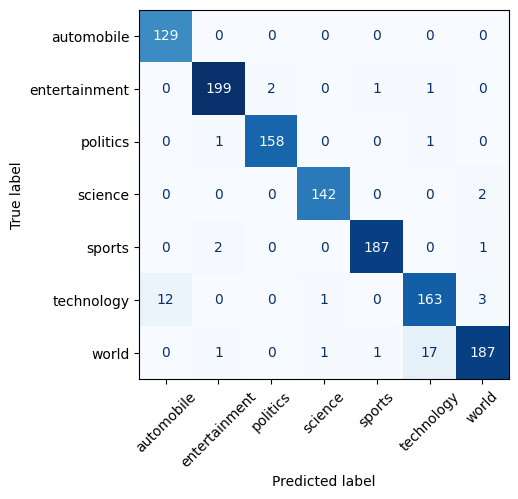

In [10]:
# plot comfusion matrix
cm = confusion_matrix(targets, preds)
ConfusionMatrixDisplay(cm, display_labels=classes).plot(
    cmap="Blues", xticks_rotation=45, colorbar=False
)
plt.show()


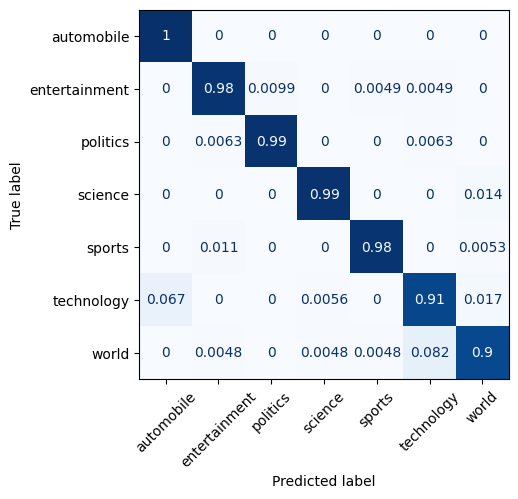

In [15]:
# plot comfusion matrix
cm = confusion_matrix(targets, preds, normalize="true")
ConfusionMatrixDisplay(cm, display_labels=classes).plot(cmap="Blues", xticks_rotation=45, colorbar=False)
plt.show()